In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile
from IPython.display import Audio
from scipy import signal
from biquadWah import biquadWah

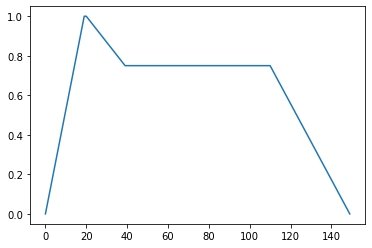

In [2]:
# ADSREXAMPLE
# This script creates a linear ADSR amplitude envelope.
#
# See also ADSR

# Number of samples per fade
a = 20
d = 20
s = 70
r = 40

sustainAmplitude = 0.75

# create each segment A, D, S, R
aFade = np.linspace(0, 1, a)
dFade = np.linspace(1, sustainAmplitude, d)
sFade = sustainAmplitude * np.ones(s)
rFade = np.linspace(sustainAmplitude, 0, r)

# Concatenates total ADSR envelope
env = np.append(aFade, dFade)
env = np.append(env, sFade)
env = np.append(env, rFade)

plt.plot(env)
plt.show()

In [3]:
# ADSR
# This function can be used to apply an ADSR envelope on to an input signal.
#
# Input Variables
#   attackTime: length of attack ramp in milliseconds
#   decayTime: length of decay ramp in milliseconds
#   sustainAmplitude: linear amplitude of sustain segment
#   releaseTime: length of release ramp in ms

def adsr(x, Fs, attackTime, decayTime, sustainAmplitude, releaseTime):
    # Convert time inputs to seconds
    attackTimeSec = attackTime/1000
    decayTimeSec = decayTime/1000
    releaseTimeSec = releaseTime/1000

    # Convert seconds to samples and determine sustain time
    a = int(np.round(attackTimeSec * Fs))   # Round each to an integer
    d = int(np.round(decayTimeSec * Fs))    # number of samples.
    r = int(np.round(releaseTimeSec * Fs))
    s = len(x) - (a + d + r) # determine length of sustain

    # Create linearly spaced fades for A, D, and R. Create hold for S.
    aFade = np.linspace(0, 1, a)
    dFade = np.linspace(1, sustainAmplitude, d)
    sFade = sustainAmplitude * np.ones(s)
    rFade = np.linspace(sustainAmplitude, 0, r)

    # Concatenates total ADSR envelope
    env = np.append(aFade, dFade)
    env = np.append(env, sFade)
    env = np.append(env, rFade)

    # Applies ADSR shaping to x
    y = x * env

    return y

In [4]:
# ENVELOPEMODULATION
# This script demonstrates the process of measuring an amplitude envelope from
# the waveform of a voice recording and using it io modulate the amplitude of
# synth recording.

# Import audio files
x, Fs = soundfile.read('Voice.wav')
synth, _ = soundfile.read('Synth.wav')

alpha = 0.9997 # feedback gain
fb = 0 # initialized value for feedback
N = len(x)
env = np.zeros(N)

for n in range (N):
    # Analyze envelope
    env[n] = (1 - alpha) * abs(x[n]) + alpha * fb
    fb = env[n]

# Make-up gain
env = 4 * env

# Amplitude modulation of envelope applied to synthsizer
out = synth * env

Audio(out, rate=Fs)

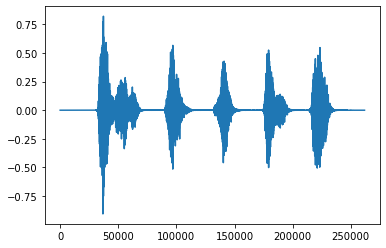

In [5]:
# VOCODEREXAMPLE
# This script demonstrates the process of creating a vocoder effect using a
# voice signal and a synth signal.

# # Import audio files
x, Fs = soundfile.read('Voice.wav')
synth, _ = soundfile.read('Synth.wav')

# Initialize filter parameters
Nyq = Fs/2  # Nyquist frequency
order = 2   # Filter order

numBands = 16

# Logarithmically spaced cutoff frequencies
# 2*10^1 - 2*10^4 (20-20k) Hz
freq = 2 * np.logspace(1, 4, numBands)

g = 0.9992  # smoothing filter gain
fb = 0  # initialized value for feedback

N = len(x)

# These arrays are used to store the filtered versions of
# the input signal. Each column stores the signal for
# each band. As an example, voxBands[:,3] stores the
# band-pass filtered signal in the fourth band.
voxBands = np.zeros((N, numBands))
synthBands = np.zeros((N, numBands))
envBands = np.zeros((N, numBands))

for band in range(numBands-1): # perform processing 1 band per loop
    # Determine lower and upper cutoff frequencies
    # of the current BPF on a normalized scale.
    Wn = np.append(freq[band], freq[band+1])
    Wn = Wn / Nyq
    b, a = signal.butter(order, Wn=Wn, btype='bandpass')

    # Filter signals and store the result
    voxBands[:, band] = signal.lfilter(b, a, x)
    synthBands[:, band] = signal.lfilter(b, a, synth)

    # Envelope measurement from vocal signal
    for n in range(N):
        envBands[n, band] = (1-g) * abs(voxBands[n, band]) + g * fb
        fb = envBands[n, band]

    fb = 0

# Perform amplitude modulation
outBands = np.zeros((len(x), numBands))
for band in range(numBands):
    # Apply the envelope of the vocal signal to the synthesizer
    # in each of the bands
    outBands[:, band] = envBands[:, band] * synthBands[:, band]

# Sum together all the bands
out = np.sum(outBands, 1)
# Make-up gain
out = 32 * out

plt.plot(out)
plt.show()

# Listen to the output and plot it
Audio(out, rate=Fs)

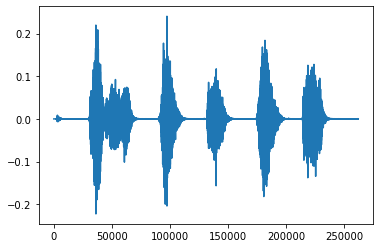

In [2]:
# CISIMULATION
# This script performs vocoding using speech and white noise. This process is used
# to simulate cochlear implants for listeners with acoustic hearing.
#
# See also VOCODEREXAMPLE

# Import audio files
x, Fs = soundfile.read('Voice.wav')
N = len(x)
noise = 0.1 * np.random.randn(N)

# Initialize filter parameters
Nyq = Fs/2  # Nyquist frequency
order = 2  # Filter order

numBands = 16

# Logarithmically space cutoff frequencies
# 2*10^1 - 2*10^4 (20-20k) Hz
freq = 2 * np.logspace(1,4,numBands)

g = 0.9992 # Smoothing filter gain
fb = 0 # Initialize feedback delay

voxBands = np.zeros((N, numBands))
noiseBands = np.zeros((N, numBands))
envBands = np.zeros((N, numBands))

for band in range(numBands-1):
    Wn = np.append(freq[band ], freq[band+1])
    Wn = Wn / Nyq
    b, a = signal.butter(order, Wn=Wn, btype='bandpass')

    # Filterbank
    voxBands[:, band] = signal.lfilter(b, a, x)
    noiseBands[:, band] = signal.lfilter(b, a, noise)

    # Envelope measurement
    for n in range(N):
        envBands[n, band] = (1-g) * abs(voxBands[n, band]) + g * fb
        fb = envBands[n, band]

    fb = 0

# Perform amplitude modulation
outBands = np.zeros((N, numBands))
for band in range(numBands):
    outBands[:, band] = envBands[:, band] * noiseBands[:, band]

# Sum together all the bands
out = np.sum(outBands, 1)
# Make-up gain
out = 32 * out

plt.plot(out)

Audio(out, rate=Fs)

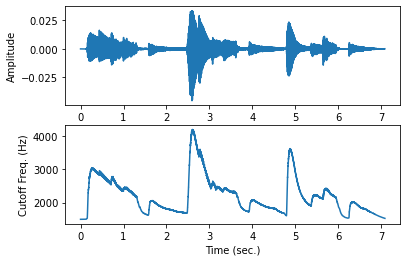

In [3]:
# ENVWAHEXAMPLE
# This script implements an env-wah effect using a bi-quad filter as the resonant
# LPF after analyzing the amplitude envelope of the input signal.
#
# See also BIQUADWAH

x, Fs = soundfile.read('AcGtr.wav')
Ts = 1/Fs
N = len(x)

# Initialize feedforward delay buffer
# (stores 2 previous samples of input)
ff = np.append(0, 0) # ff[n] = n samples of delay

# Initialize feedback delay buffer
# (stores 2 previous samples of output)
fb = np.append(0, 0) # fb[n] = n samples of delay

# Bandwidth of resonant LPF
Q = 4

# Wet/dry mix
wet = 100

# Initialize output signal
y = np.zeros(N)
# Cutoff frequency from envelope
cutoff = np.zeros(N)

# Envelope LPF parameters
alpha = 0.9995
envPreviousValue = 0

for n in range(N):
    # Envelope detection
    rect = abs(x[n])
    env = (1 - alpha) * rect + alpha * envPreviousValue
    envPreviousValue = env

    # Scale envelope for cutoff frequency of LPF
    freq = 1500 + 10000 * env

    # Use bi-quad wah effect function
    y[n], ff, fb, = biquadWah(x[n], Fs, freq, Q, ff, fb, wet)

    # Store for plotting
    cutoff[n] = freq

t = np.arange(0, N) * Ts
plt.subplot(2,1,1)
plt.plot(t, y)
plt.xlabel('Time (sec.)')
plt.ylabel('Amplitude')
plt.subplot(2,1,2)
plt.plot(t, cutoff)
plt.xlabel('Time (sec.)')
plt.ylabel('Cutoff Freq. (Hz)')

Audio(y, rate=Fs)

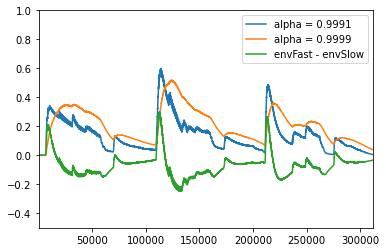

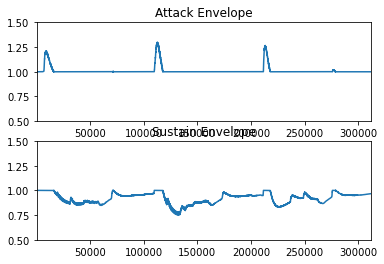

In [4]:
# TRANSIENTANALYSIS
# This script plots the amplitude envelopes used in the transient designer effect. A
# comparision is plotted of the 'fast' and 'slow' envelopes used to determine when
# 'attack' and 'sustain' is occuring in the signal.
#
# See also TRANSIENTDESIGNER, TRANSIENTEXAMPLE

x, Fs = soundfile.read('AcGtr.wav')

gFast = 0.9991 # Gain smoothing for the 'fast' envelope
fbFast = 0 # Feedback for the 'fast' envelope
gSlow = 0.9999 # Gain smoothing for the 'slow' envelope
fbSlow = 0 # Feedback for the 'slow' envelope

N = len(x)
envFast = np.zeros(N)
envSlow = np.zeros(N)
transientShaper = np.zeros(N)

for n in range(N):
    envFast[n] = (1 - gFast) * 2 * abs(x[n]) + gFast * fbFast
    fbFast = envFast[n]

    envSlow[n] = (1 - gSlow) * 3 * abs(x[n]) + gSlow * fbSlow
    fbSlow = envSlow[n]

    transientShaper[n] = envFast[n] - envSlow[n]

plt.figure(1)
plt.plot(envFast)
plt.plot(envSlow)
plt.plot(transientShaper)
plt.legend(['alpha = 0.9991', 'alpha = 0.9999', 'envFast - envSlow'])
plt.axis([1, N, -0.5, 1])
plt.show()

attack = np.zeros(N)
sustain = np.zeros(N)
for n in range(N):
    if transientShaper[n] > 0:
        attack[n] = transientShaper[n] + 1
        sustain[n] = 1

    else:
        attack[n] = 1
        sustain[n] = transientShaper[n] + 1

plt.figure(2)
plt.subplot(2,1,1) # Plot the detected attack envelope
plt.plot(attack)
plt.title('Attack Envelope')
plt.axis([1, N, 0.5, 1.5])
plt.subplot(2,1,2)
plt.plot(sustain)
plt.title('Sustain Envelope')
plt.axis([1, N, 0.5, 1.5])
plt.show()

In [5]:
# TRANSIENTDESIGNER
# This function implements the transient designer audio effect. First, a detection
# analysis is performed to determine the sections of the signal that should be
# labeled 'attack' and 'sustain'. Then the amplitude of these sections is scaled
# based on the input parameters.
#
# Input Variables
#   attack: amount to change transient (-1 dec, 0 unity, +1 inc)
#   sustain: amount to change sustain
#
# See also TRANSIENTANALYSIS

def transientDesigner(x, attack, sustain):
    N = len(x)
    # Initialize filtering parameters
    gFast = 0.9991 # Feedback gain for the 'fast' envelope
    fbFast = 0 # Variable used to store previous envelope value
    gSlow = 0.9999 # Feedback gain for 'slow' envelope
    fbSlow = 0

    envFast = np.zeros(N)
    envSlow = np.zeros(N)
    differenceEnv = np.zeros(N)

    # Measure fast and slow envelopes
    for n in range(N):
        envFast[n] = (1-gFast) * 2 * abs(x[n]) + gFast * fbFast
        fbFast = envFast[n]

        envSlow[n] = (1-gSlow) * 3 * abs(x[n]) + gSlow * fbSlow
        fbSlow = envSlow[n]

        # Create the difference envelope between 'fast' and 'slow'
        differenceEnv[n] = envFast[n] - envSlow[n]
        # Note: difference envelope will have a positive value when
        # envFast is greater than envSlow. This occurs when the signal
        # is in 'attack'. If the difference envelope is negative, then
        # the signal is in 'sustain'.

    attEnv = np.zeros(N)
    susEnv = np.zeros(N)

    # Separate attack and sustain envelopes
    for n in range(N):
        if differenceEnv[n] > 0: # 'Attack' section
            attEnv[n] = (attack * differenceEnv[n]) + 1
            susEnv[n] = 1 # No change
        else:
            attEnv[n] = 1 # No change
            susEnv[n] = (sustain * -differenceEnv[n]) + 1

    # Apply the attack and sustain envelopes
    out = (x * attEnv) * susEnv

    return out

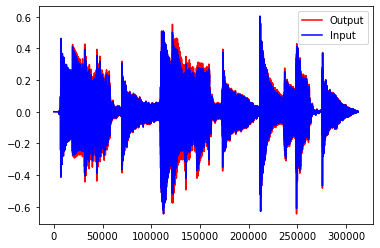

In [6]:
# TRANSIENTEXAMPLE
# This script demonstrates the transient designer function.
#
# See also TRANSIENTDESIGNER, TRANSIENTANALYSIS

x, Fs = soundfile.read('AcGtr.wav')

# Attack and sustain parameters [-1, +1]
attack = 0
sustain = 1

out = transientDesigner(x, attack, sustain)

plt.plot(out, 'r')
plt.plot(x, 'b')
plt.legend(['Output', 'Input'])
plt.show()

Audio(out, rate=Fs)
